In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import math
import QuantLib as ql
import numpy_financial as npf
# pip install numpy-financial
import scipy.optimize as optimize
from datetime import date
import pandas as pd

# 1. Simulate interest rate

### CIR Model

In [76]:
def generate_CIR(kappa,theta,sigma,r0,WAM,num_paths):
    # Generate interest rate 
    T=WAM/12
    h=1/12 # dt
    N=WAM
    size=num_paths
    r=np.ones((1,size))*r0
    zero=np.zeros(size)
    Z1=np.random.normal(0,1,(N,size))
    for i in range(N):
        m=r[i,:]+kappa*(theta-np.max([r[i,:],zero],axis=0))*h+sigma*np.sqrt(np.max([r[i,:],zero],axis=0))*np.sqrt(h)*Z1[i,:]
        r=np.append(r,[m],axis=0)
    return r

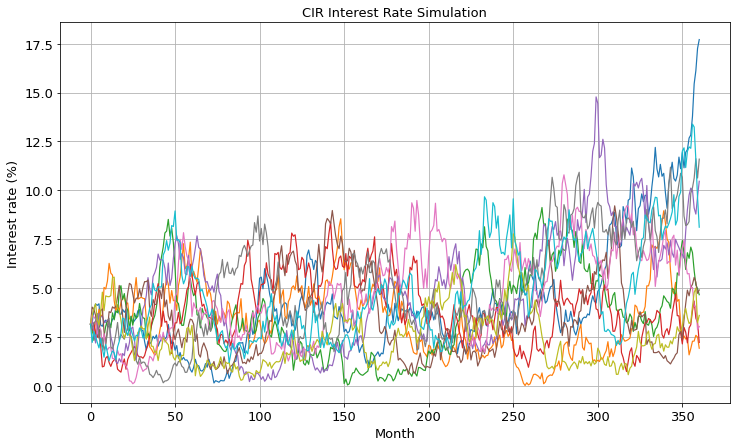

In [77]:
interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10)

plt.figure(figsize=(12,7))
for i in range(interest_paths.shape[1]):
    plt.plot(interest_paths[:,i]*100, lw=1.2)
plt.title("CIR Interest Rate Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Interest rate (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

### Generate 10 years spot rate (for calculating RI)

Calculate 10 year zero coupon bond price

In [78]:
def Zero10Yr(r0, r_mean, sigma, kappa, T, t):
    h1 = np.sqrt(kappa**2 + 2*sigma**2)
    h2 = (kappa + h1)/2
    h3 = (2*kappa*r_mean)/sigma**2
    A = ((h1 * np.exp(h2*(T - t)))/(h2 * (np.exp(h1*(T - t)) - 1) + h1))**h3
    B = (np.exp(h1*(T - t)) - 1)/(h2 * (np.exp(h1*(T - t)) - 1) + h1)
    return A*np.exp(-B*r0)

In [79]:
def spotRate_10yr(kappa,theta,sigma,r0,WAM,CIR,num_paths):
    zeros10yr = np.array(list(map(lambda rt: Zero10Yr(rt, theta, sigma, kappa, 10, 0), CIR)))
    spot_rate = -1/10*np.log(zeros10yr)
    return spot_rate

In [80]:
spot_rate=spotRate_10yr(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,CIR=interest_paths,num_paths=10)

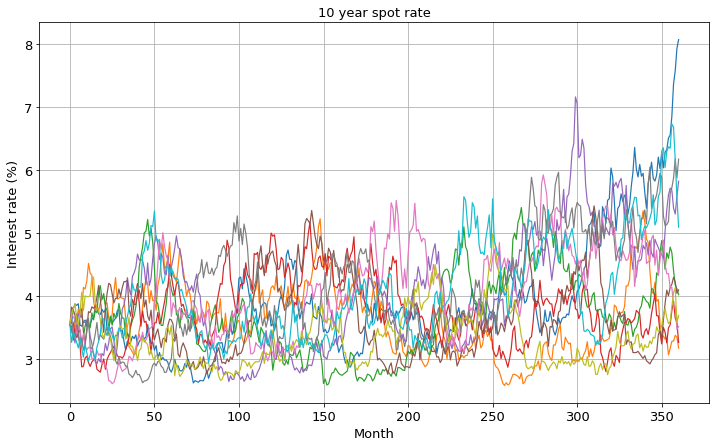

In [81]:
plt.figure(figsize=(12,7))
for i in range(spot_rate.shape[1]):
    plt.plot(spot_rate[:,i]*100, lw=1.2)
plt.title("10 year spot rate",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Interest rate (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

# 2. Prepayment

In [47]:
def prepayment(WAC,WAM,B0,spotRate_10yr,num_paths):
    # Refinancing incentive
    Mortgage_rate=spotRate_10yr[1:,:]*1.5+0.00826
    RI=(WAC+0.0075)/Mortgage_rate
#     RI=.2406-.1389*np.arctan(5.952*(1.089-(WAC+0.0075)/interest_paths[1:,:]))

    # Seasoning multiplier, unit: %
    a=np.array([[x+1 for x in range(WAM)] for x in range(num_paths)]).T
    Age=np.min([a/30,np.ones((WAM,num_paths))],axis=0)

    # Monthly multiplie, WANxnum_paths matrix
    temp=np.array([0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98])
    testf=np.ones(WAM)
    for i in range(WAM):
        index=(i+6)%12
        testf[i]=temp[index]
    MM=np.array([testf for x in range(num_paths)]).T

    # Burnout multiplier
    B=np.ones((1,num_paths))*B0 # Need to revise
    for i in range(WAM-1):
        n=B[-1,:]*0.8
        B=np.append(B,[n],axis=0)
    BM=0.3+0.7*(B/B0)

    # CPR
    CPR=np.maximum(RI*Age*MM*BM,np.zeros((WAM,num_paths)))
    CPR=np.minimum(CPR,np.ones((WAM,num_paths)))
    return CPR,RI,Age,MM,BM

In [82]:
CPR1,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,spotRate_10yr=interest_paths,num_paths=10)

In [83]:
CPR2,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,spotRate_10yr=spot_rate,num_paths=10)

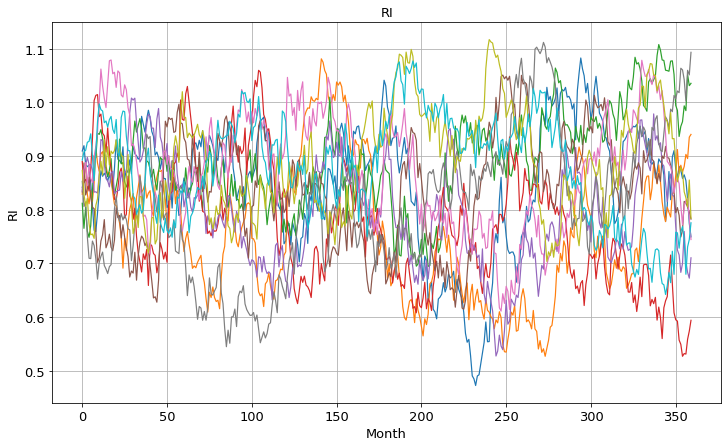

In [49]:
plt.figure(figsize=(12,7))
plt.plot(RI,lw=1.2)
plt.title("RI",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("RI",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

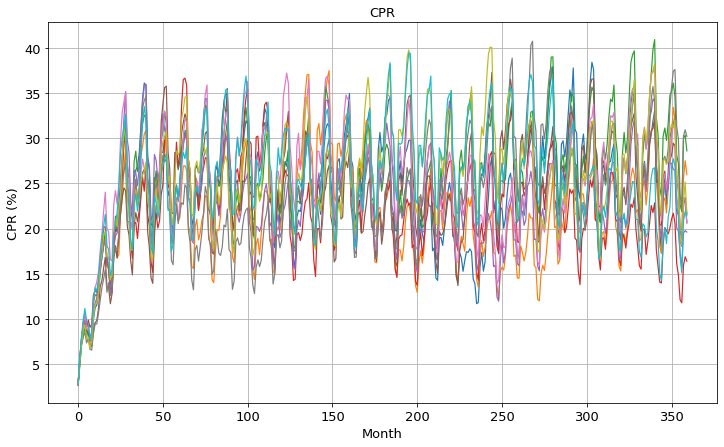

In [50]:
plt.figure(figsize=(12,7))
plt.plot(CPR*100,lw=1.2)
plt.title("CPR",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("CPR (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

# 3. Cash flow

### Generate matrix:

In [133]:
CPR2

array([[0.02774509, 0.02872707, 0.02810315, ..., 0.02836602, 0.02693529,
        0.02995345],
       [0.05075258, 0.055863  , 0.0573465 , ..., 0.05360696, 0.05071188,
        0.05535199],
       [0.06981491, 0.07443904, 0.07759079, ..., 0.07424478, 0.06973174,
        0.0790097 ],
       ...,
       [0.12279698, 0.25385137, 0.21096136, ..., 0.14825002, 0.21322653,
        0.14861221],
       [0.12139569, 0.26374396, 0.22043987, ..., 0.16023731, 0.2491279 ,
        0.16833146],
       [0.11211156, 0.2593674 , 0.21124674, ..., 0.14371968, 0.22757746,
        0.17119807]])

In [171]:
def generate_CF(CPR_matrix,B0,WAC_month,WAM,num_paths):
    CPR=CPR_matrix
    # genarate period / date series
    period=np.array([[x for x in range(0,WAM+1)] for x in range(num_paths)]).T

    # generate MB
    MB=np.ones((WAM+1,num_paths))*B0

    # # generate Mortgage payment
    MP0=-1*npf.pmt(rate=WAC_month,nper=WAM-1,pv=B0)
    MP=np.ones((WAM+1,num_paths))*MP0

    # generate interest payment
    IP=MB*WAC_month

    # generate principal paying in mortgage payment
    PrinP=MP-IP

    # generate prepayment in mortgage payment
    CPR0=CPR[0,0]
    SMM0=1-np.power(1-CPR0,1/12)
    PrePay=(MB-PrinP)*SMM0/100

    # generate cash flow 
    CF=MP+PrePay
    
    # generate total principal payment
    TP=PrinP+PrePay

    # Calculate all cash flow table in matrix
    for i in range(1,WAM): # i from 1 to 359
        MB[i,:]=MB[i-1,:]-PrinP[i-1,:]-PrePay[i-1,:]
        MP[i,:]=-1*npf.pmt(rate=WAC_month,nper=WAM-i,pv=MB[i,:])
        IP[i,:]=MB[i,:]*WAC_month
        PrinP[i,:]= MP[i,:]-IP[i,:]
        PrePay[i,:]=(MB[i,:]-PrinP[i,:])*CPR[i,:]/12 # Here CPR is monthly rate
        CF[i,:]=IP[i,:]+PrinP[i,:]+PrePay[i,:]
        TP[i,:]=PrePay[i,:]+PrinP[i,:]

    MB[-1,:]=0
    IP[-1,:]=MB[-2,:]*WAC_month
    MP[-1,:]=MB[-2,:]+IP[-1,:]
    PrinP[-1,:]=MB[-2,:]
    PrePay[-1,:]=0
    CF[-1,:]=MP[-1,:]
    TP[-1,:]=PrinP[-1,:]
    return period,MB,MP,IP,PrinP,PrePay,CF,TP

In [135]:
period,MB,MP,IP,PrinP,PrePay,CF,TP = generate_CF(CPR2,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=10)

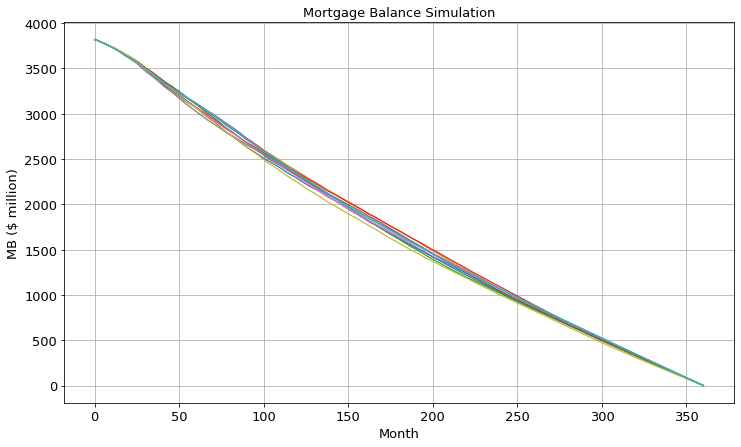

In [136]:
plt.figure(figsize=(12,7))
plt.plot(MB/1000000,lw=1.2)
plt.title("Mortgage Balance Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("MB ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

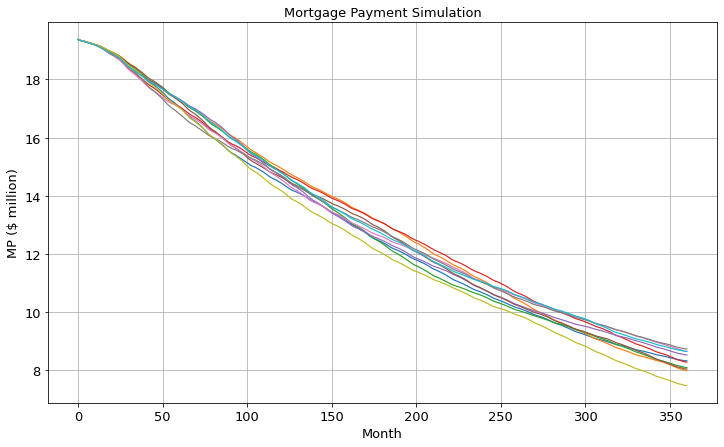

In [137]:
plt.figure(figsize=(12,7))
plt.plot(MP/1000000,lw=1.2)
plt.title("Mortgage Payment Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("MP ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

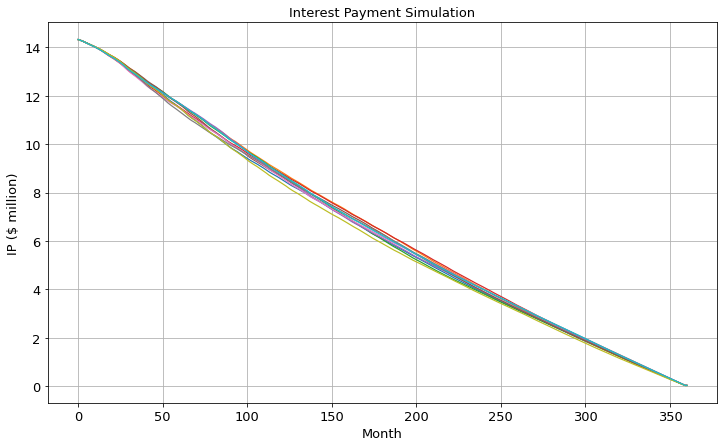

In [138]:
plt.figure(figsize=(12,7))
plt.plot(IP/1000000,lw=1.2)
plt.title("Interest Payment Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("IP ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

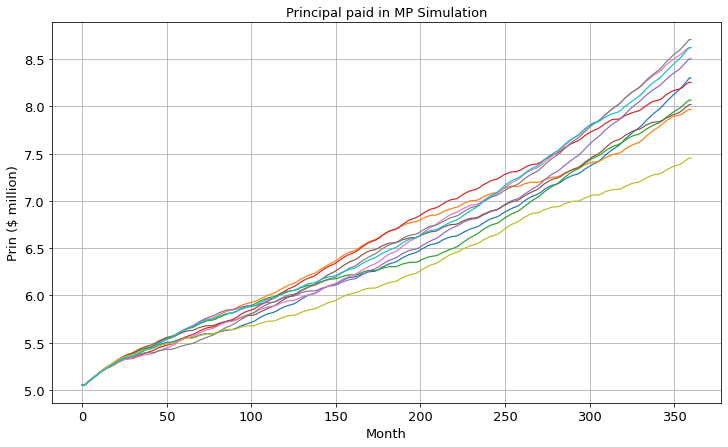

In [139]:
plt.figure(figsize=(12,7))
plt.plot(PrinP/1000000,lw=1.2)
plt.title("Principal paid in MP Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Prin ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

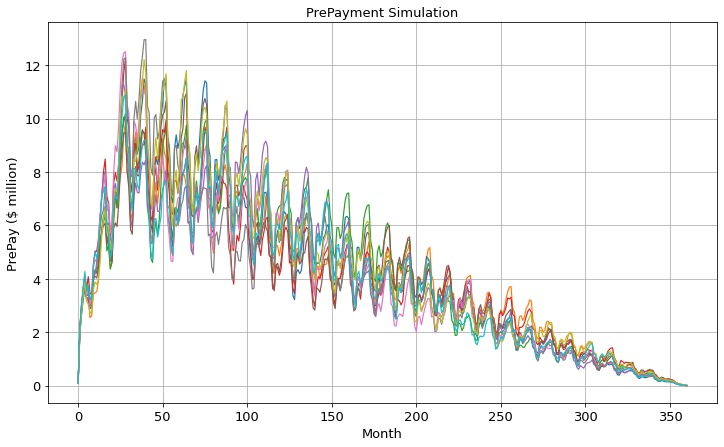

In [140]:
plt.figure(figsize=(12,7))
plt.plot(PrePay/1000000,lw=1.2)
plt.title("PrePayment Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("PrePay ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

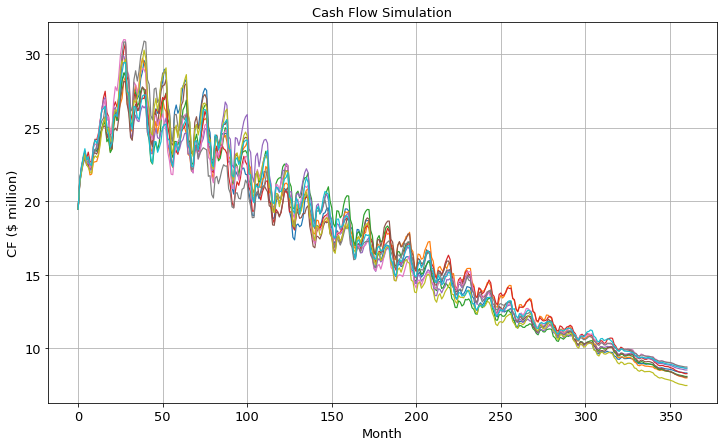

In [141]:
plt.figure(figsize=(12,7))
plt.plot(CF/1000000,lw=1.2)
plt.title("Cash Flow Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("CF ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

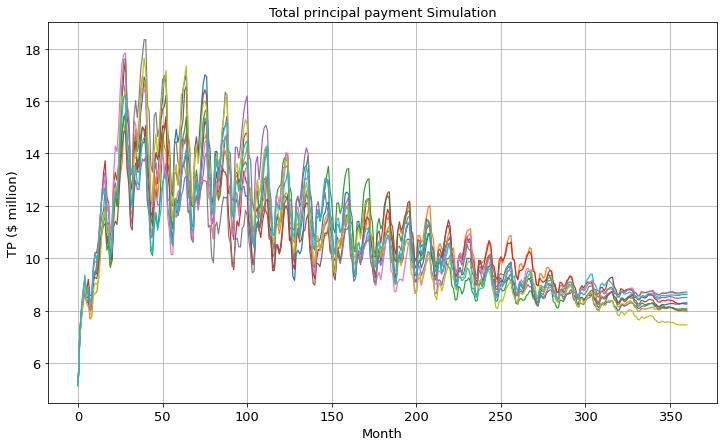

In [142]:
plt.figure(figsize=(12,7))
plt.plot(TP/1000000,lw=1.2)
plt.title("Total principal payment Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("TP ($ million)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

### cash flow table (one example)

In [143]:
unit=1000000
frame = {'Time':pd.Series(period[:,0]),'Mortgage_Balance ($M)':pd.Series(np.round_(MB[:,0]/unit,decimals=2)),
         'Mortgage_Payment ($M)':pd.Series(np.round_(MP[:,0]/unit,decimals=2)), 'Interest_Payment ($M)':pd.Series(np.round_(IP[:,0]/unit,decimals=2)),
         'Principal_Payment ($M)':pd.Series(np.round_(PrinP[:,0]/unit,decimals=2)), 'Prepayment ($M)':pd.Series(np.round_(PrePay[:,0]/unit,decimals=2)),
         'Cash Flow ($M)':pd.Series(np.round_(CF[:,0]/unit,decimals=2))}
CF_table=pd.DataFrame(frame)
CF_table

,Time,Mortgage_Balance ($M),Mortgage_Payment ($M),Interest_Payment ($M),Principal_Payment ($M),Prepayment ($M),Cash Flow ($M)
0,0,3817.75,19.37,14.32,5.05,0.09,19.46
1,1,3812.61,19.34,14.30,5.05,1.93,21.28
2,2,3805.63,19.33,14.27,5.06,2.65,21.99
3,3,3797.92,19.32,14.24,5.08,3.23,22.55
4,4,3789.61,19.30,14.21,5.09,3.60,22.90
...,...,...,...,...,...,...,...
356,356,33.13,8.36,0.12,8.24,0.02,8.38
357,357,24.87,8.35,0.09,8.26,0.02,8.37
358,358,16.59,8.34,0.06,8.28,0.01,8.35
359,359,8.30,8.33,0.03,8.30,-0.00,8.33


# 4. MBS Valuation

### Present Value, YTM, quotes

In [144]:
def MBS_price(CF_matrix,interest_paths,period_matrix,B0,WAC_month,OAS):
    CF=CF_matrix
    period=period_matrix
    # Find NPV
    DCF=CF[1:,:]/((1+interest_paths[1:,:]/12+OAS/12)**(period[1:,:]))
    PV=np.sum(DCF,axis=0)
    bond_quotes=(PV/B0)*100
#     print("Bond Quotes: {}".format(round(np.mean(bond_quotes),4)))

    guess=0.01
    # ytm_func = lambda y: np.sum(CF[1:,:]/((1+y/12)**(period[1:,:])),axis=0) - PV
    ytm_func = lambda y: \
        sum([B0*WAC_month/(1+y)**(t) for t in period[1:,0]]) + \
        B0/(1+y)**(period[-1,0]) - np.mean(PV)
    ytm=optimize.newton(ytm_func, guess)
    
#     print("Yield to Maturity (Annualized):  %.2f%%" % (ytm*1200))
    return bond_quotes,PV,ytm*12

In [146]:
bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0)
print("Bond Quotes: {}".format(round(np.mean(bond_quotes),4)))
print("Yield to Maturity (Annualized):  %.2f%%" % (ytm*100))

Bond Quotes: 109.492
Yield to Maturity (Annualized):  3.96%


### Compare with real price:

In [147]:
df=pd.read_csv('UM30_HP_0615.csv').dropna()
df.DATES=pd.to_datetime(df.DATES)
discount_rate=np.mean(interest_paths[0,:])
df['Esti']=np.mean(bond_quotes)/(1+discount_rate/365)**df['t_diff']

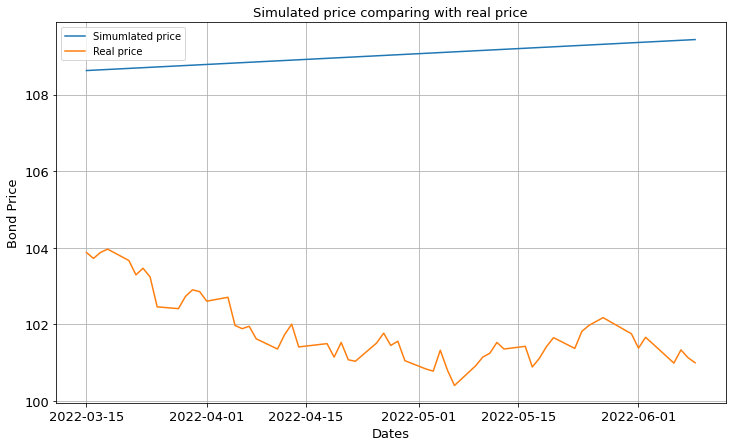

In [148]:
plt.figure(figsize=(12,7))
plt.plot(df.DATES,df.Esti,label='Simumlated price')
plt.plot(df.DATES,df.price,label='Real price')
plt.title("Simulated price comparing with real price",fontsize=13)
plt.xlabel("Dates",fontsize=13)
plt.ylabel("Bond Price",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend()
plt.show()

### Price:

In [153]:
interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10000)
CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,spotRate_10yr=interest_paths,num_paths=10000)
period,MB,MP,IP,PrinP,PrePay,CF,TP = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=10000)
bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0)

In [155]:
ytm

0.038258814939152175

### Duration:

### Calculate duration by changing interest rate:

In [35]:
# change small interest rate
def duration_interest(delta,num_paths):
    interest_paths=generate_CIR(kappa=0.2,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=num_paths)

    CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths,num_paths=num_paths)
    new_CPR,new_RI,new_Age,new_MM,new_BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths+delta,num_paths=num_paths)

    period,MB,MP,IP,PrinP,PrePay,CF = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=num_paths)
    new_period,new_MB,new_MP,new_IP,new_PrinP,new_PrePay,new_CF = generate_CF(new_CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=num_paths)

    bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0)
    new_bond_quotes,new_PV,new_ytm=MBS_price(new_CF,interest_paths+delta,new_period,B0=3817752472,WAC_month=0.045/12,OAS=0)
    return (np.mean(bond_quotes)-np.mean(new_bond_quotes))/delta

In [36]:
duration_interest(delta=0.00001,num_paths=10000)

Bond Quotes: 113.6938
Yield to Maturity (Annualized):  3.74%
Bond Quotes: 113.6839
Yield to Maturity (Annualized):  3.74%


989.1108740816888

### Calculate duration by changing ytm:

In [37]:
def duration_ytm(delta,ytm,B0,WAC_month):
    new_ytm=(ytm*100+delta)/100
    old_BP=(sum([B0*WAC_month/(1+ytm)**(t) for t in period[1:,0]])+B0/(1+ytm)**(period[-1,0]))*100/B0
    new_BP=(sum([B0*WAC_month/(1+new_ytm)**(t) for t in period[1:,0]])+B0/(1+new_ytm)**(period[-1,0]))*100/B0
    duration=(old_BP-new_BP)/delta
    return duration

In [38]:
duration_ytm(delta=0.000001,ytm=ytm,B0=3817752472,WAC_month=0.045/12)

2.5703091282025525

## Option Adjusted Spread:

In [156]:
hp_df=pd.read_csv('UM30_HP_0620.csv')
hp_df['DATES']=pd.to_datetime(hp_df['DATES'])
# We set Jun. 25 is t0
hp_df['t_difference']=0
for i in range(hp_df.shape[0]):
    hp_df['t_difference'][i]=(pd.to_datetime(["2022-06-25"])-hp_df['DATES'][i])[0].days
hp_df

<ipython-input-156-a3b357efcd34>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_df['t_difference'][i]=(pd.to_datetime(["2022-06-25"])-hp_df['DATES'][i])[0].days


,DATES,price,t_difference
0,2022-02-28,105.414062,117
1,2022-03-01,105.414062,116
2,2022-03-02,105.226562,115
3,2022-03-03,105.250000,114
4,2022-03-04,105.429688,113
...,...,...,...
67,2022-06-03,101.492200,22
68,2022-06-06,100.984400,19
69,2022-06-07,101.328150,18
70,2022-06-08,101.125050,17


In [157]:
def calculate_OAS(CF_matrix,interest_paths,period_matrix,B0,WAC_month,hp_df):
    CF=CF_matrix
    period=period_matrix
    test=hp_df[hp_df.t_difference<30].copy()
    OAS_list=[]
    for j in range(test.shape[0]):
        TD=test.iloc[j,2]
        adjust_period=period+TD/30
        guess=0.01
        OAS_func = lambda y: np.mean((np.sum(CF/((1+interest_paths/12+y/12)**(adjust_period)),axis=0)/B0)*100) - test.iloc[j,1]
        OAS=optimize.newton(OAS_func, guess)
        OAS_list.append(OAS)
        print('The OAS at '+str(test.iloc[j,0])[:10]+': '+str(round(OAS*100, 5))+' (%)')
    return test.iloc[:,0],OAS_list

In [172]:
interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10000)
spot_rate=spotRate_10yr(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,CIR=interest_paths,num_paths=10000)
CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,spotRate_10yr=spot_rate,num_paths=10000)
period,MB,MP,IP,PrinP,PrePay,CF,TP = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=10000)
# bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0)
date,OAS=calculate_OAS(CF,interest_paths,period,3817752472,0.045/12,hp_df)

The OAS at 2022-05-27: 0.50182 (%)
The OAS at 2022-05-31: 0.61748 (%)
The OAS at 2022-06-01: 0.71432 (%)
The OAS at 2022-06-02: 0.64648 (%)
The OAS at 2022-06-03: 0.69046 (%)
The OAS at 2022-06-06: 0.8275 (%)
The OAS at 2022-06-07: 0.74319 (%)
The OAS at 2022-06-08: 0.79757 (%)
The OAS at 2022-06-09: 0.8343 (%)


The negative/positive OAS shows that the model underpriced/overpriced the MBS relative to the market

In [173]:
date

63   2022-05-27
64   2022-05-31
65   2022-06-01
66   2022-06-02
67   2022-06-03
68   2022-06-06
69   2022-06-07
70   2022-06-08
71   2022-06-09
Name: DATES, dtype: datetime64[ns]

In [174]:
OAS

[0.0050182086900414985,
 0.006174825621504563,
 0.007143166925625777,
 0.006464786082452505,
 0.006904641523849079,
 0.008274961099640746,
 0.007431912824745463,
 0.007975722868177102,
 0.008343004597124509]

### OAS Duration

In [165]:
def pertubPrice(OAS):
    # pertub OAS to respective prices
    dx = 0.01*(0.01/100)
    # P+, P-, P0
    P_up=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=OAS+dx)[0]
    P_down=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=OAS-dx)[0]
    P0=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=OAS)[0]
    return [np.mean(P0), np.mean(P_up), np.mean(P_down)]

In [166]:
def OAS_duration(P_up, P_down, P0):
    dx = 0.01*(0.01/100)
    duration = (P_down - P_up)/(2*dx*P0)
    return duration

In [167]:
def OAS_convexity(P_up, P_down, P0):
    dx = 0.01*(0.01/100)
    convexity = (P_down + P_up - 2*P0)/(2 * (dx)**2 * P0)
    return convexity

In [175]:
P0, P_up, P_down = pertubPrice(OAS=0)
durationOAS = OAS_duration(P_up, P_down, P0)
convexityOAS = OAS_convexity(P_up, P_down, P0)
print("The duration of option adjusted spread : ", durationOAS)
print("The conexity of option adjusted spread : ", convexityOAS)

The duration of option adjusted spread :  3.95036702243723
The conexity of option adjusted spread :  13.334481605286586


In [297]:
OAS

[0.009286810080834793,
 0.009764171854862282,
 0.010161151790472462,
 0.00988426813536674,
 0.010064798767967231,
 0.0106260683686519,
 0.010282470960127854,
 0.010504812913298592,
 0.010654976657340534]

In [176]:
DurwithOAS=[]
for i in range(len(OAS)):
    P0, P_up, P_down = pertubPrice(OAS=OAS[i])
    a=OAS_duration(P_up, P_down, P0)
    DurwithOAS.append(a)
DurwithOAS

[3.8956443678990675,
 3.8832538567803443,
 3.872943046026215,
 3.880160409683,
 3.8754775595013595,
 3.8609636671794334,
 3.869879510351517,
 3.8641234362666097,
 3.8602459194159184]

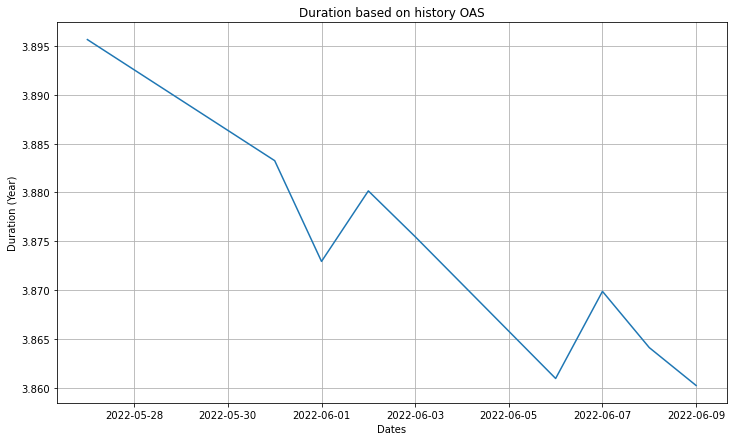

In [209]:
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(12,7))
plt.title('Duration based on history OAS')
plt.plot(date.dt.date,DurwithOAS)
plt.xlabel('Dates')
plt.ylabel('Duration (Year)')
x_major_locator=MultipleLocator(2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid()
plt.show()

In [191]:
list(date.dt.date)

[datetime.date(2022, 5, 27),
 datetime.date(2022, 5, 31),
 datetime.date(2022, 6, 1),
 datetime.date(2022, 6, 2),
 datetime.date(2022, 6, 3),
 datetime.date(2022, 6, 6),
 datetime.date(2022, 6, 7),
 datetime.date(2022, 6, 8),
 datetime.date(2022, 6, 9)]

In [194]:
date.dt.date

63    2022-05-27
64    2022-05-31
65    2022-06-01
66    2022-06-02
67    2022-06-03
68    2022-06-06
69    2022-06-07
70    2022-06-08
71    2022-06-09
Name: DATES, dtype: object